In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn==0.24.0
# !pip install keras
# !pip install catboost
# !pip install tensorflow
# !pip install dill
# !pip install ipywidgets

In [2]:
import pandas as pd
import os
import csv
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import catboost
from numpy import percentile
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt 

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError

In [3]:
RANDOM_SEED = 42

In [4]:
def data_outlier(columns_list, df):

    data_out = pd.DataFrame(data = {'name': [], 'count': [], 'min': [], 'mean': [], 'max': [], 
                                    'low_range': [], 'upper_range': [], 'out_count': []
                                   })
    for column_name in columns_list:
        perc25 = percentile(df[column_name], 25)
        perc75 = percentile(df[column_name], 75)
        iqr = perc75 - perc25
        low_range = perc25 - 1.5 * iqr
        upper_range = perc75 + 1.5 * iqr
        out_count = df[column_name].apply(
            lambda x: None if x < low_range or x > upper_range else x).isna().sum()
        
        to_append = [column_name, df[column_name].count(), round(df[column_name].min(), 2), 
                     round(df[column_name].mean(), 2), round(df[column_name].max(), 2), 
                     round(low_range, 2), round(upper_range, 2), out_count]
        data_out_length = len(data_out)
        data_out.loc[data_out_length] = to_append
    
    data_out = data_out.set_index('name')
        
    return data_out

In [5]:
# Рассмотрим как распределены числовые признаки в трейне

def train_hist_plot(column_name, df_train):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    new_series_log = np.log(df_train[column_name] + 1)

    ax[0].hist(df_train[column_name], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(column_name)

    ax[1].hist(new_series_log, rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of ' + column_name)

    plt.show()
    
def test_hist_plot(column_name, df_test):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    new_series_log = np.log(df_test[column_name] + 1)

    ax[0].hist(df_test[column_name], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(column_name)

    ax[1].hist(new_series_log, rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of ' + column_name)

    plt.show()

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
df = pd.read_csv("data_new.csv")


In [8]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [9]:
df.shape

(377185, 18)

In [10]:
df[df['target'].isna()].shape

(2481, 18)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [12]:
print("Percent NULL values\n")
round(df.isna().sum() / df.shape[0] * 100, 4)

Percent NULL values



status          10.5831
private pool    98.8915
propertyType     9.2085
street           0.0005
baths           28.1925
homeFacts        0.0000
fireplace       72.6620
city             0.0090
schools          0.0000
sqft            10.7579
zipcode          0.0000
beds            24.2009
state            0.0000
stories         39.9578
mls-id          93.3873
PrivatePool     89.3127
MlsId           17.7314
target           0.6578
dtype: float64

Удаляем столбцы, где процент NULL значений больше 40%

In [13]:
df.drop(['private pool', 'fireplace', 'mls-id', 'PrivatePool'], axis=1, inplace=True)

In [14]:
df.nunique()

status             159
propertyType      1280
street          337076
baths              229
homeFacts       321009
city              2026
schools         297365
sqft             25405
zipcode           4549
beds              1184
state               39
stories            348
MlsId           232944
target           43939
dtype: int64

status

In [15]:
df['status'] = df['status'].str.lower()

In [16]:
df['status'] = df['status'].str.replace('[{}]'.format(string.punctuation), ' ').str.replace('[{}]'.format(string.digits), ' ').apply(lambda x: " ".join(str(x).split()))
df['status'] = df['status'].apply(lambda x: None if x is None else None if str(x) == 'nan' else x)
df['status'].value_counts(dropna=False)

C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/1285135392.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['status'] = df['status'].str.replace('[{}]'.format(string.punctuation), ' ').str.replace('[{}]'.format(string.digits), ' ').apply(lambda x: " ".join(str(x).split()))


for sale                   199571
active                     105207
NaN                         39918
foreclosure                  6769
new construction             5475
                            ...  
conting accpt backups           1
conditional contract            1
pending take backups            1
pending w backup wanted         1
backup                          1
Name: status, Length: 104, dtype: int64

In [17]:
df['status'].nunique()

103

In [18]:
df['status'].isna().sum()

39918

propertyType 

In [19]:
df['propertyType'].sample(10)

13609                  condo
98786     single-family home
94041                    NaN
25726     single-family home
117274         Single Family
101018             townhouse
320321    Single Family Home
69373          Single Family
131772         Single Family
372573    single-family home
Name: propertyType, dtype: object

In [20]:
df['propertyType'] = df['propertyType'].str.lower()
df['propertyType'] = df['propertyType'].str.replace('[{}]'.format(string.punctuation), ' ').apply(lambda x: " ".join(str(x).split()))
df['propertyType'] = df['propertyType'].str.replace('one', '1').str.replace('two', '2')

C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/2162173882.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['propertyType'] = df['propertyType'].str.replace('[{}]'.format(string.punctuation), ' ').apply(lambda x: " ".join(str(x).split()))


In [21]:
df['propertyType'].value_counts()[20:40]

contemporary modern           1010
apartment                      922
2 stories                      911
mfd mobile home                792
single detached                751
detached 2 story               638
2 story                        596
transitional                   560
cooperative                    535
florida                        530
bungalow                       442
farms ranches                  371
garden home                    305
cape cod                       281
2 stories traditional          280
spanish mediterranean          272
other style                    249
1 story traditional            238
other                          232
condo townhome traditional     225
Name: propertyType, dtype: int64

In [22]:
df['stories_dop'] = df['propertyType'].str.findall(r'[a-z0-9]+ story|[a-z0-9]+ stories').apply(lambda x: None if len(x) == 0 else x[-1])

df['stories_dop'].value_counts(dropna=False)

NaN          369527
1 story        4440
2 stories      1558
2 story        1466
3 stories       134
8 stories        38
7 stories        15
3 story           6
5 story           1
Name: stories_dop, dtype: int64

In [23]:
set_story = set(df['stories_dop'].dropna())
for y in set_story:
  df['propertyType'] = df['propertyType'].str.replace(y, '')

In [24]:
df['propertyType'] = df['propertyType'].str.replace('home', '')
df['propertyType'] = df['propertyType'].apply(lambda x: None if x == '' else
                                              None if str(x) == 'nan' else 
                                              None if str(x) == 'None' else " ".join(str(x).split()))

In [25]:
df['propertyType'].nunique()

1112

In [26]:
df['propertyType'].value_counts(dropna=False)

single family                                               186803
condo                                                        42530
NaN                                                          38211
lot land                                                     20552
townhouse                                                    18401
                                                             ...  
single detached southwestern                                     1
other ranch                                                      1
traditional colonial federal                                     1
condo town french split level                                    1
bilevel converted dwelling loft with bedrooms condo unit         1
Name: propertyType, Length: 1113, dtype: int64

In [27]:
df['propertyType'] = df['propertyType'].str.replace(r'[0-9]+[a-z]+[0-9]+', '').str.strip()
df['propertyType'] = df['propertyType'].str.replace(r'\b[0-9]+\b', '').str.strip()
df['propertyType'] = df['propertyType'].str.replace(r'\b[a-z]{2}\b', '').str.strip()

C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/1507094604.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['propertyType'] = df['propertyType'].str.replace(r'[0-9]+[a-z]+[0-9]+', '').str.strip()
C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/1507094604.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['propertyType'] = df['propertyType'].str.replace(r'\b[0-9]+\b', '').str.strip()
C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/1507094604.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['propertyType'] = df['propertyType'].str.replace(r'\b[a-z]{2}\b', '').str.strip()


In [28]:
# Взять базовые значения

df['propertyType'] = df['propertyType'].apply(lambda x: None if x is None else
                                                        None if str(x) == '' else
                                                        " ".join(x.split()[:3]))

street пока не рарабатываем, сделаем токенайзером

baths

In [29]:
df['baths'] = df['baths'].apply(lambda x: None if x is np.nan else x)
df['baths'].value_counts(dropna=False)

NaN           106338
2 Baths        52466
3 Baths        35506
2              20452
2.0            16576
               ...  
4.75 Baths         1
5.25 Baths         1
41.0               1
1.8 Baths          1
44.0               1
Name: baths, Length: 230, dtype: int64

In [30]:
punct = '~—\-:'

df['baths'] = df['baths'].str.lower().str.replace('[a-z]+\.?', '').str.replace(',', '.').str.replace('[{}]'.format(punct), ' ')
df['baths'] = df['baths'].apply(lambda x: None if str(x).strip() =='' else x)

C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/913977552.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['baths'] = df['baths'].str.lower().str.replace('[a-z]+\.?', '').str.replace(',', '.').str.replace('[{}]'.format(punct), ' ')


In [31]:
df['baths'] = df['baths'].str.findall('[0-9]+\.?[0-9]*')
df['baths'] = df['baths'].apply(lambda x: None if x is None else x[0]).astype(float)

df['baths'].value_counts(dropna=False)

NaN      107838
2.0      103519
3.0       66683
4.0       26333
1.0       17787
          ...  
5.2           1
116.0         1
35.0          1
241.0         1
68.0          1
Name: baths, Length: 85, dtype: int64

city

In [32]:
# Получается слишком много уникальных значений даже после выбора паттернов, удалим признак

sqft

In [33]:
df['sqft'].value_counts(dropna=False)

NaN                                        40577
0                                          11854
1,200 sqft                                   839
1,000 sqft                                   654
1,100 sqft                                   573
                                           ...  
9,914                                          1
Total interior livable area: 3,055 sqft        1
5,177                                          1
11620                                          1
Total interior livable area: 4,615 sqft        1
Name: sqft, Length: 25406, dtype: int64

In [34]:
df['sqft'] = df['sqft'].apply(lambda x: None if x is np.nan else 
                                        None if str(x) == '' else str(x))

In [35]:
df['sqft'] = df['sqft'].str.replace(',', '')
df['sqft'] = df['sqft'].str.findall('[0-9]+\.?[0-9]*')
df['sqft'] = df['sqft'].apply(lambda x: None if x is None else 
                                        None if len(x) == 0 else int(x[0]))

In [36]:
df['sqft'].value_counts(dropna=False)

NaN        41397
0.0        11854
1200.0      1426
1000.0      1027
1500.0      1014
           ...  
8074.0         1
13418.0        1
20816.0        1
11170.0        1
13870.0        1
Name: sqft, Length: 9897, dtype: int64

zipcode

In [37]:
df['zipcode'].value_counts(dropna=False)

32137         2141
33131         1563
34747         1488
78245         1390
34759         1333
              ... 
27613-4237       1
43054            1
41630            1
27615-3709       1
64015            1
Name: zipcode, Length: 4549, dtype: int64

In [38]:
# Приведем все значения к 5-значному формату

df['zipcode'] = df['zipcode'].str.replace('\-[0-9]*', '').apply(lambda x: None if x is None else 
                                                                None if x == '' else 
                                                                ('0000' + str(x))[-5:])

C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/2538331529.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['zipcode'] = df['zipcode'].str.replace('\-[0-9]*', '').apply(lambda x: None if x is None else


beds

In [39]:
df['beds'] = df['beds'].apply(lambda x: None if x is np.nan else x).str.lower()

In [40]:
df['beds'].value_counts(dropna=False)

NaN            91282
3 beds         53459
4 beds         35418
3              31406
2 beds         26362
               ...  
8,023 sqft         1
10,193 sqft        1
8.93 acres         1
5,510 sqft         1
8,479 sqft         1
Name: beds, Length: 1185, dtype: int64

In [41]:
# Данные по sqft выделим из столбца beds

index_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')), ['sqft','beds']].index
new_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')), ['sqft','beds']]
new_sqft['sqft'] = new_sqft['beds'].str.strip().str.replace(',', '.').str.findall('[0-9]+\.*[0-9]*').apply(lambda x: None if len(x) == 0 else x[0]).astype(float)

df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')), 'sqft'] = new_sqft['sqft']
df.loc[(df['beds'].isna()==False) & (df['beds'].str.contains('sqft')), 'beds'] = None

In [42]:
# Данные по sqft в акрах выделим из столбца beds

index_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')), ['sqft','beds']].index
new_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')), ['sqft','beds']]
new_sqft['sqft'] = new_sqft['beds'].str.strip().str.replace(',', '.').str.findall('[0-9]+\.*[0-9]*').apply(lambda x: None if len(x) == 0 else x[0]).astype(float)
new_sqft['sqft'] = (new_sqft['sqft'] * 43560).astype(int)

df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')), 'sqft'] = new_sqft['sqft']
df.loc[(df['beds'].isna()==False) & (df['beds'].str.contains('acre')), 'beds'] = None

In [43]:
df['beds'] = df['beds'].str.replace('bedrooms', 'beds').str.replace('bd', 'beds')
df['beds'] = df['beds'].str.replace('or more ', '').str.replace('#', '').str.replace(r'[0-9]+[a-z]+', '')

C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/1489790419.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['beds'] = df['beds'].str.replace('or more ', '').str.replace('#', '').str.replace(r'[0-9]+[a-z]+', '')


In [44]:
df.loc[(df['beds'].isna()==False) & (df['beds'].str.strip().str.contains('^[a-z,\-%@#_:;~ ]+$')), 'beds'] = None

In [45]:
# Данные по baths выделим из столбца beds

new_bath = df.loc[(df['baths'].isna()) & (df['beds'].str.contains('bath')), 'beds'].str.findall('[0-9a-z ]+ bath').apply(lambda x: x[0].split()[0]).astype(float)
df.loc[new_bath.index, 'baths'] = new_bath

In [46]:
df['beds'].isna().sum()

# Уже на данном этапе слишком много пустых значений, удалим данный столбец

111391

state

In [47]:
df['state'].value_counts(dropna=False)

FL    115449
TX     83786
NY     24479
CA     23386
NC     21862
TN     18340
WA     13826
OH     12588
IL      8939
NV      8482
GA      6705
CO      6404
PA      5561
MI      5161
DC      4674
AZ      3347
IN      3328
OR      2789
MA      1516
UT      1325
MD      1090
VT       868
MO       866
VA       801
WI       452
NJ       436
ME       259
IA       242
KY        90
OK        49
MS        40
SC        28
MT         7
DE         5
Fl         1
BA         1
AL         1
OT         1
OS         1
Name: state, dtype: int64

stories

In [48]:
df['stories_dop'] = df['stories_dop'].apply(lambda x: None if x is None else x.split()[0]).astype(float)
df['stories_dop'].value_counts(dropna=False)

NaN    369527
1.0      4440
2.0      3024
3.0       140
8.0        38
7.0        15
5.0         1
Name: stories_dop, dtype: int64

In [49]:
df['stories'] = df['stories'].str.lower()
df['stories'].value_counts(dropna=False)[:10]

# Слишком много пустых значений, даже с учетом добвления stories_dop, удалим оба столбца

NaN    150715
1.0     67454
2.0     55283
1       23086
2       18146
3.0     11275
0.0      7241
one      5758
0        4273
3        4228
Name: stories, dtype: int64

MlsId

In [50]:
df = df.drop('MlsId', axis=1)

homeFacts

In [51]:
df['homeFacts'] = df['homeFacts'].apply(lambda x: eval(x)).apply(lambda x: list(x.values())[0])

In [52]:
list_columns = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']

for column in enumerate(list_columns):
    df[column[1]] = None
    df[column[1]] = df['homeFacts'].apply(lambda x: None if x[column[0]].get('factValue') == '' else  x[column[0]].get('factValue'))

Year built

In [53]:
df['Year built'].value_counts(dropna=False)

NaN     62374
2019    32171
2006     8008
2005     7503
2007     7152
        ...  
1807        1
1809        1
1700        1
1823        1
1804        1
Name: Year built, Length: 230, dtype: int64

In [54]:
df.loc[df['Year built'].str.len() > 4, 'Year built'] = None
df.loc[df['Year built'].str.len() < 4, 'Year built'] = None


In [55]:
df['Year built'] = df['Year built'].apply(lambda x: None if x is None else
                                          None if 'No' in x else 
                                          None if str(x) == 'nan' else
                                          None if str(x) == '' else int(x))

Remodeled year

In [56]:
df['Remodeled year'].value_counts(dropna=False)

# Слишком много пропусков, удалим потом столбец

NaN     226110
2006      5538
2005      4817
2007      4387
2008      3796
         ...  
1870         1
1845         1
1846         1
1111         1
1862         1
Name: Remodeled year, Length: 154, dtype: int64

Heating

In [57]:
df['Heating'].value_counts(dropna=False)[:10]

# Слишком много пропусков и непоказательных данных, удалим потом столбец

NaN                 109332
Forced Air           82807
Forced air           51506
Other                29623
Electric             10211
Gas                   9296
No Data               8611
Central Air           7814
Central Electric      7112
Central               6247
Name: Heating, dtype: int64

Cooling

In [58]:
df['Cooling'].value_counts(dropna=False)

# Слишком много пропусков и непоказательных данных, удалим потом столбец

Central                                                                158754
NaN                                                                    123967
Central Air                                                             14384
No Data                                                                 10616
Has Cooling                                                              9730
                                                                        ...  
Central Gas, Propane, Zoned                                                 1
Other (See Remarks), Panel/Floor/Wall, Window Unit                          1
Multi Units, Zoned Cooling                                                  1
Central Air, g-Energy Star HVAC, Gas Hot Air/Furnace, Multizone A/C         1
Central A/C (Gas), Central Heat (Gas), Heat Pump                            1
Name: Cooling, Length: 1445, dtype: int64

Parking

In [59]:
df['Parking'].value_counts(dropna=False)[:10]

# Слишком много пропусков и непоказательных данных, удалим потом столбец

NaN                         175420
Attached Garage              70752
2 spaces                     28063
1 space                      14252
No Data                      13334
Detached Garage              13201
Carport                       7743
3 spaces                      4724
Off Street                    3622
Carport, Attached Garage      3025
Name: Parking, dtype: int64

lotsize sqft

In [60]:
df[['lotsize', 'sqft']].sample(5)

,lotsize,sqft
35244,None,1553.0
329148,"3,250 sqft",2032.0
68991,None,1755.0
271710,"7,288 Sq. Ft.",1672.0
50258,2500 sqft,750.0


In [61]:
df['lotsize'] = df['lotsize'].str.lower().str.replace(r'[\-,—]', '').str.strip().apply(lambda x: None if x is None else
                                                                                      None if 'no' in x else
                                                                                      None if x == '' else x)

C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/2695916822.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['lotsize'] = df['lotsize'].str.lower().str.replace(r'[\-,—]', '').str.strip().apply(lambda x: None if x is None else


In [62]:
# Заполним те значения признака sqft которые пустые из признака lotsize

# acres
new_lot_size = df.loc[(df['sqft'].isna()) & (df['lotsize'].isna()==False) & (df['lotsize'].str.contains('sq'))]['lotsize']
new_lot_size = new_lot_size.str.lower().str.replace(r'[a-z \.]', '').str.strip()
new_lot_size = new_lot_size.apply(lambda x: None if x is None else 
                                  None if x is np.nan else
                                  None if x == '' else int(float(x)))
df.loc[new_lot_size.index, 'sqft'] = new_lot_size

# acres
new_lot_size = df.loc[(df['sqft'].isna()) & (df['lotsize'].isna()==False) & (df['lotsize'].str.contains('acre'))]['lotsize']
new_lot_size = new_lot_size.str.lower().str.replace('[a-z ]', '').str.strip()
new_lot_size = new_lot_size.apply(lambda x: None if x is None else float(x) * 43560).astype(int)
df.loc[new_lot_size.index, 'sqft'] = new_lot_size

C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/2796084492.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  new_lot_size = new_lot_size.str.lower().str.replace(r'[a-z \.]', '').str.strip()
C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/2796084492.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  new_lot_size = new_lot_size.str.lower().str.replace('[a-z ]', '').str.strip()


In [63]:
df['sqft'].isna().sum()

11890

Price/sqft

In [64]:
df['Price/sqft'].sample(10)

134922         $134/sqft
42178               $209
87699               $111
172852              None
296277    $141 / Sq. Ft.
93642          $111/sqft
234970         $239/sqft
73258               $192
71601          $345/sqft
28288               $180
Name: Price/sqft, dtype: object

In [65]:
df['Price/sqft'] = df['Price/sqft'].str.lower().str.replace(r'[,/$a-z\. ]', '').str.strip().apply(lambda x: None if x is None else
                                                                                      None if x == '' else int(x))

C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/810406887.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Price/sqft'] = df['Price/sqft'].str.lower().str.replace(r'[,/$a-z\. ]', '').str.strip().apply(lambda x: None if x is None else


schools

In [66]:
df['schools'] = df['schools'].apply(lambda x: eval(x)[0])

In [67]:
list_keys = ['data', 'name', 'rating']
# name не будем брать

list_columns = ['Distance', 'Grades', 'rating']
# Grades не будем брать слишком запутано

df['Distance'] = df['schools'].apply(lambda x: None if x.get('data').get('Distance') is None else x.get('data').get('Distance'))
df['rating'] = df['schools'].apply(lambda x: None if x.get('rating') is None else x.get('rating'))

In [68]:
df['Distance'] = df['Distance'].apply(lambda x: [float(y.replace('mi', '').strip()) for y in x])

In [69]:
df['Distance'] = df['Distance'].apply(lambda x: list(filter(None, x)))

In [70]:
df['Distance'].sample(10)

12255                    [0.6, 0.8, 2.6, 0.3, 2.3]
71626                           [2.84, 0.71, 1.38]
135125                           [0.3, 3.72, 1.42]
86330     [1.5, 1.6, 3.0, 2.9, 0.4, 3.7, 1.0, 1.2]
46239                                 [0.17, 1.78]
263291                        [0.3, 0.1, 0.1, 0.2]
150183                   [0.4, 0.7, 0.8, 0.3, 0.8]
25976                            [0.47, 1.95, 0.6]
305026                          [1.02, 1.37, 1.04]
11777                              [3.7, 5.4, 3.4]
Name: Distance, dtype: object

In [71]:
df['rating'] = df['rating'].apply(lambda x: [None if "NR" in str(y) else
                                             None if "None" in str(y) else
                                             None if "NA" in str(y) else
                                             None if str(y) == '' else
                                             int(str(y).split('/')[0]) if "/" in str(y) else
                                             int(y) for y in x])

In [72]:
df['rating'] = df['rating'].apply(lambda x: list(filter(None, x)))

In [73]:
df['rating'].sample(10)

312638             [2, 3, 3]
187773    [7, 5, 7, 5, 5, 6]
209942             [2, 2, 3]
127899         [5, 6, 3, 10]
306503             [8, 2, 6]
59239              [6, 2, 4]
154800             [5, 1, 3]
304892             [7, 8, 8]
232102                [7, 3]
177348            [5, 10, 5]
Name: rating, dtype: object

target

In [74]:
df['target'].value_counts(dropna=False)

NaN          2481
$225,000     1462
$275,000     1355
$250,000     1312
$350,000     1296
             ... 
$390,359        1
$458,900+       1
274,359         1
$273,490+       1
$171,306        1
Name: target, Length: 43940, dtype: int64

In [75]:
df['target'] = df['target'].apply(lambda x: None if x is np.nan else x)

In [76]:
punct = '$,+\-/'
df['target'] = df['target'].str.replace('[a-z]', '').str.replace('[{}]'.format(punct), '').str.strip()

C:\Users\Timofey\AppData\Local\Temp/ipykernel_4592/1235027060.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['target'] = df['target'].str.replace('[a-z]', '').str.replace('[{}]'.format(punct), '').str.strip()


In [77]:
df['target'] = df['target'].apply(lambda x: None if x is None else int(x.split()[0]))

In [78]:
df['target'].value_counts(dropna=False)

NaN         2481
225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
            ... 
236070.0       1
752911.0       1
73360.0        1
455740.0       1
171306.0       1
Name: target, Length: 34233, dtype: int64

target Price/sqft

In [79]:
# Заполним те значения признака sqft которые пустые из признака Price/sqft и признака target

new_lot_size = df.loc[(df['sqft'].isna()) & (df['target'].isna()==False) & (df['Price/sqft'].isna()==False)][['Price/sqft', 'target']]
new_lot_size['sqft'] = (new_lot_size['target'] / new_lot_size['Price/sqft']).astype(int)
df.loc[new_lot_size.index, 'sqft'] = new_lot_size['sqft']

# Заполним те значения признака Price/sqft которые пустые из признака sqft и признака target

new_prsq = df.loc[(df['sqft'].isna()==False) & (df['target'].isna()==False) & (df['Price/sqft'].isna())][['sqft', 'target']]
new_prsq['Price/sqft'] = round(new_prsq['target'] / new_prsq['sqft'])
df.loc[new_prsq.index, 'Price/sqft'] = new_prsq['Price/sqft']

# future engeneer

In [80]:
# Сделаем копию исходного датасета для будущей обработки текста

df_text = df.copy()

In [81]:
df.sample(5)

,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,...,stories_dop,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,Distance,rating
45182,active,condo town row,3216 Casita Ct Unit 111,2.0,"[{'factValue': '2013', 'factLabel': 'Year buil...",Bryan,"{'rating': ['1', '2', '3', '4', '4', '8', 'NR'...",1474.0,77807,3,...,NaN,2013.0,None,None,Central Electric,None,4400,271.0,"[1.1, 2.9, 4.5, 3.0, 3.3, 3.8, 1.0, 2.9]","[1, 2, 3, 4, 4, 8]"
68436,for sale,single family,17608 Osborne St,4.0,"[{'factValue': '1953', 'factLabel': 'Year buil...",Sherwood Forest,"{'rating': ['5/10', '5/10', '7/10'], 'data': {...",3200.0,91325,6 beds,...,NaN,1953.0,2007,Forced Air,Central,Carport,0.42 acres,366.0,"[0.86, 0.66, 0.91]","[5, 5, 7]"
312131,for sale,condo,35 Queensberry St APT 17,1.0,"[{'factValue': '1899', 'factLabel': 'Year buil...",Boston,"{'rating': ['2/10', '9/10'], 'data': {'Distanc...",555.0,02215,1,...,NaN,1899.0,1987,Other,No Data,On street,None,935.0,"[0.6, 0.5]","[2, 9]"
45843,for sale,single family,1561 Mar Vic Ln,2.0,"[{'factValue': '1962', 'factLabel': 'Year buil...",Jacksonville,"{'rating': ['3/10', '3/10', '4/10'], 'data': {...",1414.0,32218,3 beds,...,NaN,1962.0,1962,Forced Air,Central,None,0.26 acres,99.0,"[0.49, 0.62, 5.06]","[3, 3, 4]"
342574,for sale,single family,30213 Del Rey Rd,4.0,"[{'factValue': '1988', 'factLabel': 'Year buil...",Temecula,"{'rating': ['8/10', '7/10', '9/10'], 'data': {...",4461.0,92591,5 beds,...,NaN,1988.0,None,Forced air,Central,6 spaces,1.02 acres,235.0,"[1.3, 0.4, 1.5]","[8, 7, 9]"


In [82]:
# Доля Null значений в трейне и тесте

print('                Train          Test\n')

train_shape = df[df['target'].isna() == False].shape[0] 
test_shape = df[df['target'].isna()].shape[0]

for x in df.columns:
    train_null = df[df['target'].isna() == False][x].isna().sum()
    test_null = df[df['target'].isna()][x].isna().sum()
    print((x + ':' + ' '*15)[:15] + (str(round(train_null / train_shape * 100, 4)) + ' '*15)[:15] + str(round(test_null / test_shape * 100, 4)))


                Train          Test

status:        10.4768        26.6425
propertyType:  10.1611        7.2551
street:        0.0005         0.0
baths:         28.5164        39.5002
homeFacts:     0.0            0.0
city:          0.0091         0.0
schools:       0.0            0.0
sqft:          3.0437         5.1592
zipcode:       0.0005         0.0
beds:          29.5623        24.9899
state:         0.0            0.0
stories:       39.9766        37.1221
target:        0.0            100.0
stories_dop:   97.9565        99.9597
Year built:    16.8856        13.2608
Remodeled year:60.0124        50.0202
Heating:       28.9962        27.4889
Cooling:       32.8457        35.9936
Parking:       46.5744        36.4369
lotsize:       24.4324        19.6292
Price/sqft:    3.0437         85.8122
Distance:      0.0            0.0
rating:        0.0            0.0


In [83]:
# Копируем пока весь датафрейм, чтобы потом выделить тектовые поля для nlp
df_nlp = df[['street', 'city']].copy()

In [84]:
# Удалим признаки которые не обрабатывали, так как текста
df = df.drop(['street', 'city'], axis=1)

# Удалим признаки ненужные
df = df.drop(['homeFacts', 'schools', 'stories_dop', 'lotsize'], axis=1)

# # Удалим столбцы, в которых много пустых значений либо вообще, либо много пустых значений в тесте
df = df.drop(['stories', 'baths', 'beds', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'Price/sqft'], axis=1)
df = df.drop(['status'], axis=1)


In [85]:
# Содаем новые признаки

import numpy as np

df['dist_max'] = df['Distance'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else max(x))
df['dist_min'] = df['Distance'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else min(x))

In [86]:
df['rate_max'] = df['rating'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else max(x))
df['rate_min'] = df['rating'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else min(x))

In [87]:
df = df.drop(['Distance', 'rating'], axis=1)

# Train Test

In [88]:
df_train = df[df['target'].isna() == False].copy()
df_test = df[df['target'].isna()].copy()
df_test['target'] = 0

In [89]:
df_train.head()

,propertyType,sqft,zipcode,state,target,Year built,dist_max,dist_min,rate_max,rate_min
0,single family,2900.0,28387,NC,418000.0,2019.0,12.60,2.70,7.0,4.0
1,single family,1947.0,99216,WA,310000.0,2019.0,1.65,1.01,4.0,4.0
2,single family,3000.0,90049,CA,2895000.0,1961.0,2.63,1.19,8.0,4.0
3,single family,6457.0,75205,TX,2395000.0,2006.0,1.05,0.10,10.0,9.0
4,lot land,10019.0,32908,FL,5000.0,NaN,5.96,3.03,5.0,4.0


In [90]:
df_train.isna().sum()

# Мало значений null удалим их

propertyType    38074
sqft            11405
zipcode             2
state               0
target              0
Year built      63271
dist_max         4258
dist_min         4258
rate_max         5117
rate_min         5117
dtype: int64

In [91]:
df_train = df_train.dropna(axis=0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285190 entries, 0 to 377184
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   propertyType  285190 non-null  object 
 1   sqft          285190 non-null  float64
 2   zipcode       285190 non-null  object 
 3   state         285190 non-null  object 
 4   target        285190 non-null  float64
 5   Year built    285190 non-null  float64
 6   dist_max      285190 non-null  float64
 7   dist_min      285190 non-null  float64
 8   rate_max      285190 non-null  float64
 9   rate_min      285190 non-null  float64
dtypes: float64(7), object(3)
memory usage: 23.9+ MB


In [92]:
df_test.isna().sum()

# Мало нулевых значений, заполним их

propertyType    180
sqft            128
zipcode           0
state             0
target            0
Year built      329
dist_max         27
dist_min         27
rate_max         35
rate_min         35
dtype: int64

Заполнение null значение в тесте

<AxesSubplot:>

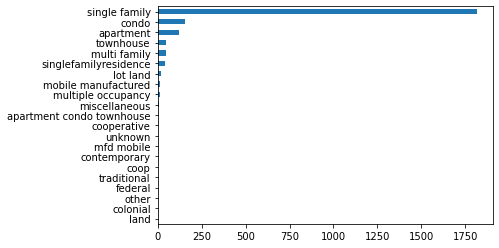

In [93]:
df_test['propertyType'].value_counts(ascending=True).plot.barh()

In [94]:
# Заменим null значения
df_test.loc[df_test['propertyType'].isna(), 'propertyType'] = 'other'

In [95]:
mean_sqft = round(df_test['sqft'].dropna().mean())

df_test.loc[df_test['sqft'].isna(), 'sqft'] = mean_sqft

In [96]:
mean_dist_max = round(df_test['dist_max'].dropna().mean())

df_test.loc[df_test['dist_max'].isna(), 'dist_max'] = mean_dist_max

In [97]:
mean_dist_min = round(df_test['dist_min'].dropna().mean())

df_test.loc[df_test['dist_min'].isna(), 'dist_min'] = mean_dist_min

In [98]:
mean_rate_max = round(df_test['rate_max'].dropna().mean())

df_test.loc[df_test['rate_max'].isna(), 'rate_max'] = mean_rate_max

In [99]:
mean_rate_min = round(df_test['rate_min'].dropna().mean())

df_test.loc[df_test['rate_min'].isna(), 'rate_min'] = mean_rate_min

In [100]:
year_mean = round(df_test['Year built'].dropna().mean())

df_test.loc[df_test['Year built'].isna(), 'Year built'] = year_mean

In [101]:
# Дополнительно выделить столбцы с Null значениями!

Обработка финального датасета

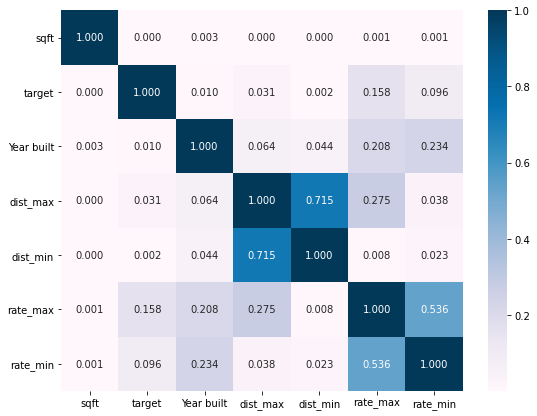

In [102]:
# Рассмотрим матрицу корреляции для начального удаления сильно скоррелированных признаков

plt.figure(figsize=(9,7))

sns.heatmap(df_train.corr().abs(), annot=True, fmt='.3f', cmap='PuBu')
plt.yticks(rotation=0)
plt.show()

In [103]:
# Очень сильная корреляция между dist_max и dist_min, возможно потом удалим

In [104]:
df.columns

Index(['propertyType', 'sqft', 'zipcode', 'state', 'target', 'Year built',
       'dist_max', 'dist_min', 'rate_max', 'rate_min'],
      dtype='object')

In [105]:
# Задаем типы переменных

categorical_features = ['propertyType', 'zipcode', 'state']
numerical_features = ['sqft', 'Year built', 'dist_max', 'dist_min', 'rate_max', 'rate_min']
value = ['target']

In [106]:
# Смотрим выбросы в трейне

data_out = data_outlier(numerical_features + value, df_train)
data_out

,count,min,mean,max,low_range,upper_range,out_count
name,,,,,,,
sqft,285190.0,0.00,11465.41,7.959794e+08,-773.50,4702.50,17206.0
Year built,285190.0,1057.00,1979.10,2.025000e+03,1879.50,2083.50,739.0
dist_max,285190.0,0.02,4.91,1.591090e+03,-3.50,10.10,32788.0
dist_min,285190.0,0.01,1.08,1.590380e+03,-0.95,2.49,22413.0
rate_max,285190.0,1.00,6.72,1.000000e+01,-1.00,15.00,0.0
rate_min,285190.0,1.00,3.66,1.000000e+01,-2.50,9.50,474.0
target,285190.0,1.00,652171.00,1.950000e+08,-374500.00,1183900.00,28982.0


# Рассмотрим числовые признаки по-отдельности

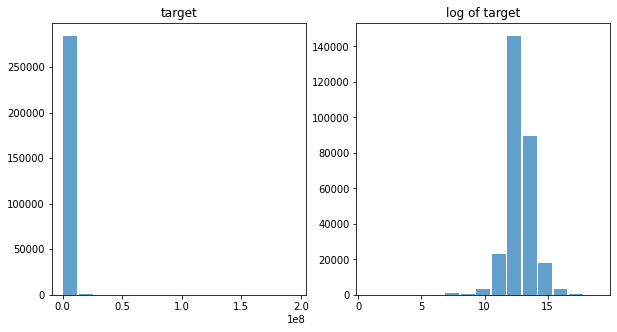

In [107]:
# target

train_hist_plot('target', df_train)

In [108]:
df_train = df_train[(df_train['target'] > 70_000) & (df_train['target'] < 2_000_000)]

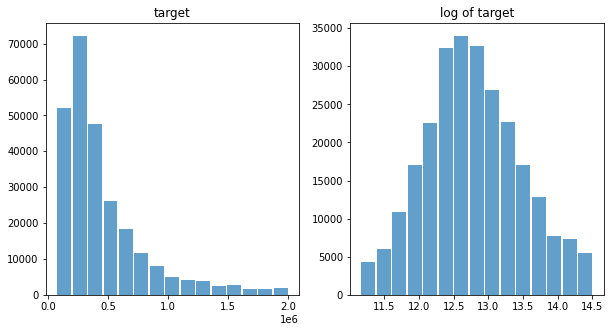

In [109]:
train_hist_plot('target', df_train[(df_train['target'] > 70_000) & (df_train['target'] < 2_000_000)])

In [110]:
df_train['target_log'] = np.log(df_train['target'] + 1)
df_test['target_log'] = 0

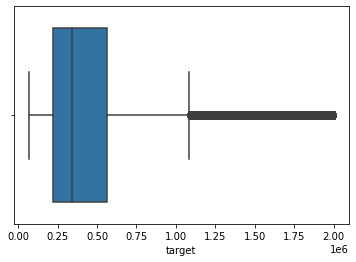

,count,min,mean,max,low_range,upper_range,out_count
target,285190.0,1.0,652171.0,195000000.0,-374500.0,1183900.0,28982.0


In [111]:
# График выбросов
sns.boxplot(x=df_train["target"])
plt.show()

# Выбросы
data_out.loc['target'].to_frame().T

In [112]:
# Убираем выбросы
# low_r = data_out.loc['target', 'low_range']
# upp_r = data_out.loc['target', 'upper_range']

# df_train = df_train[(df_train['target'] >= low_r) & (df_train['target'] <= upp_r)]

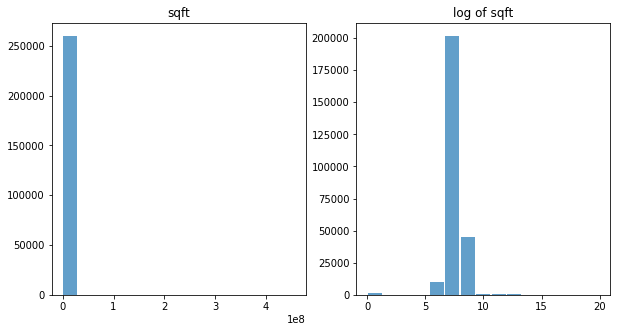

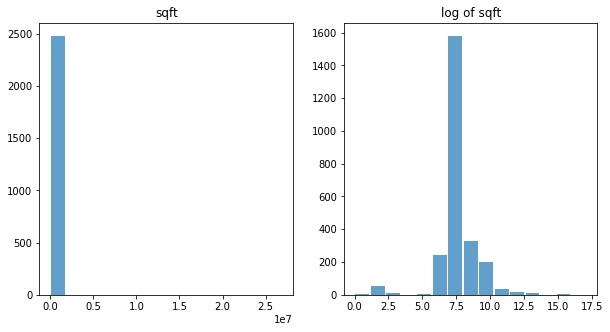

In [113]:
# sqft
train_hist_plot('sqft', df_train)
test_hist_plot('sqft', df_test)

In [114]:
df_train = df_train[(df_train['sqft'] > 500) & (df_train['sqft'] < 7_000)]

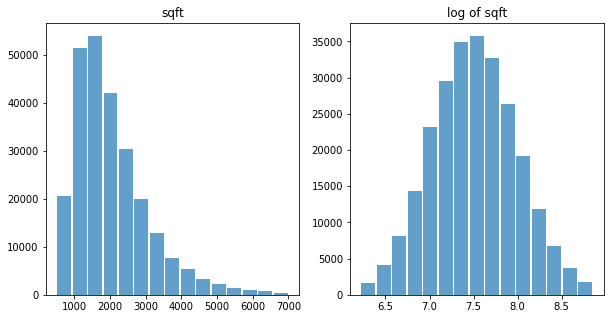

In [115]:
train_hist_plot('sqft', df_train[(df_train['sqft'] > 500) & (df_train['sqft'] < 7_000)])

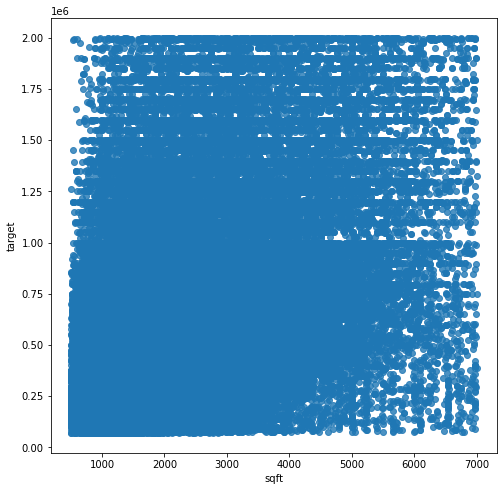

In [116]:
plt.figure(figsize = (8,8))
sns.regplot(data=df_train, y="target", x="sqft", fit_reg=False)
plt.show()

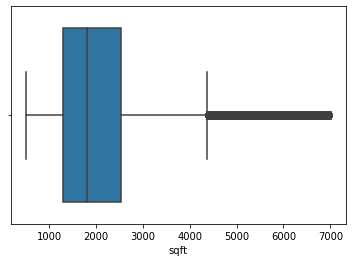

,count,min,mean,max,low_range,upper_range,out_count
sqft,285190.0,0.0,11465.41,795979430.0,-773.5,4702.5,17206.0


In [117]:
# График выбросов
sns.boxplot(x=df_train["sqft"])
plt.show()

# Выбросы
data_out.loc['sqft'].to_frame().T

In [118]:
df_train['sqft_log'] = np.log(df_train['sqft'] + 1)
df_test['sqft_log'] = np.log(df_test['sqft'] + 1)

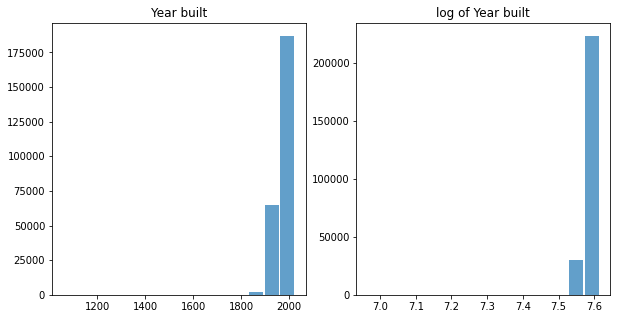

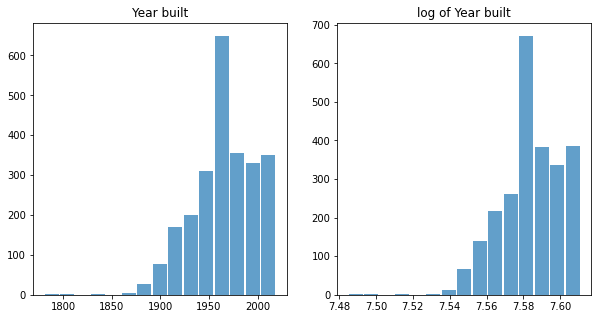

In [119]:
# Year built

train_hist_plot('Year built', df_train)
test_hist_plot('Year built', df_test)

In [120]:
# min_year_test = df_test['Year built'].min()

# # Удалим значения из трейна, не входящие в тест
# df_train = df_train[df_train['Year built'] >= min_year_test]

In [121]:
df_train = df_train[(df_train['Year built'] > 1900) & (df_train['Year built'] <= 2020)]

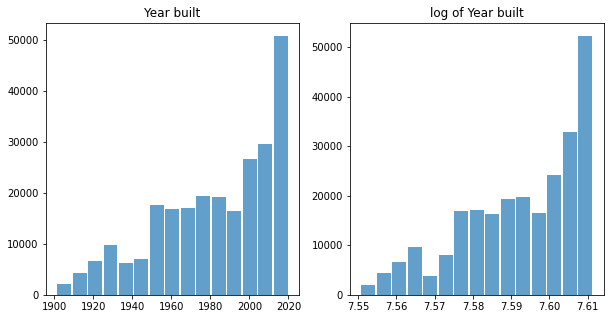

In [122]:
train_hist_plot('Year built', df_train[(df_train['Year built'] > 1900) & (df_train['Year built'] <= 2020)])

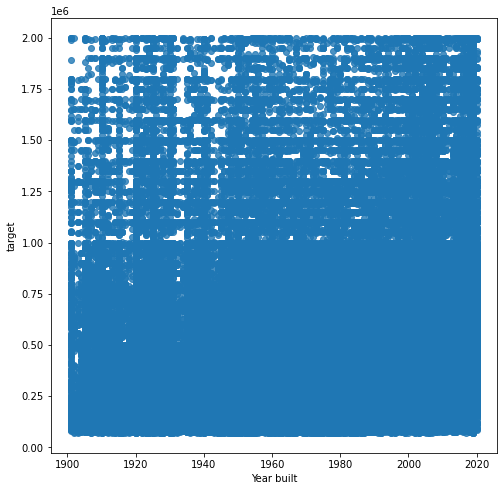

In [123]:
plt.figure(figsize = (8,8))
sns.regplot(data=df_train, y="target", x="Year built", fit_reg=False)
plt.show()

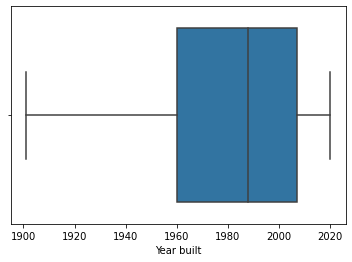

,count,min,mean,max,low_range,upper_range,out_count
Year built,285190.0,1057.0,1979.1,2025.0,1879.5,2083.5,739.0


In [124]:
# График выбросов
sns.boxplot(x=df_train["Year built"])
plt.show()

# Выбросы
data_out.loc['Year built'].to_frame().T

In [125]:
df_train['year_built_log'] = np.log(df_train['Year built'] + 1)
df_test['year_built_log'] = np.log(df_test['Year built'] + 1)

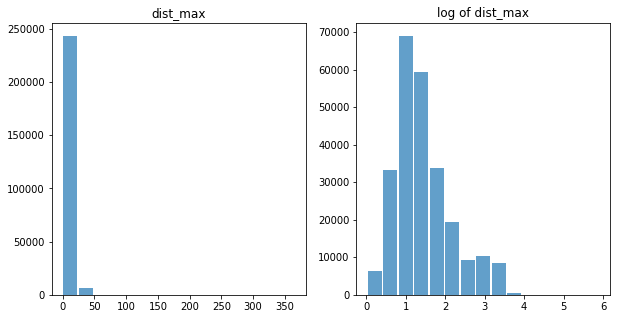

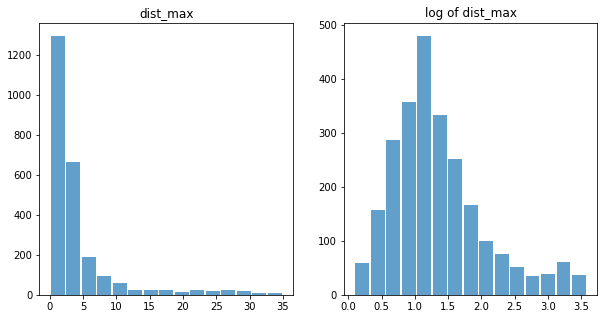

In [126]:
# dist_max

train_hist_plot('dist_max', df_train)
test_hist_plot('dist_max', df_test)

In [127]:
df_train = df_train[df_train['dist_max'] <= 34]

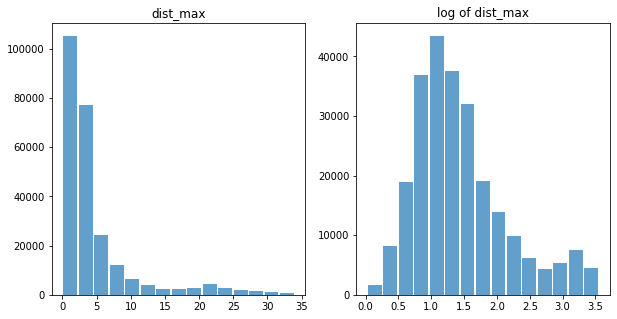

In [128]:
train_hist_plot('dist_max', df_train[df_train['dist_max'] <= 34])

In [129]:
df_train['dist_max_log'] = np.log(df_train['dist_max'] + 1)
df_test['dist_max_log'] = np.log(df_test['dist_max'] + 1)

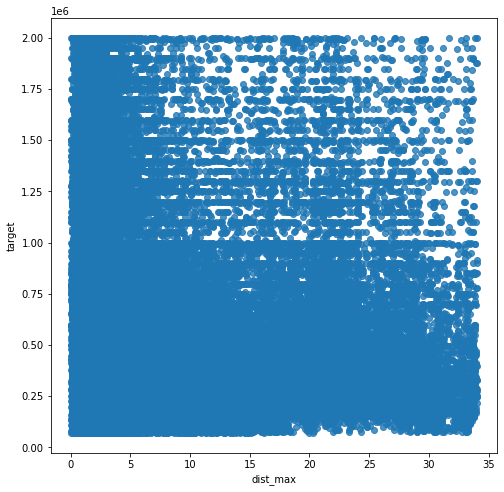

In [130]:
plt.figure(figsize = (8, 8))
sns.regplot(data=df_train, y="target", x="dist_max", fit_reg=False)
plt.show()

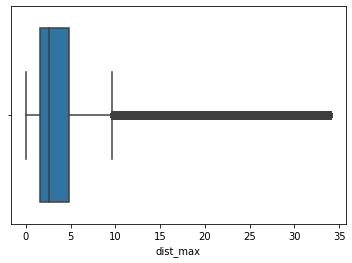

,count,min,mean,max,low_range,upper_range,out_count
dist_max,285190.0,0.02,4.91,1591.09,-3.5,10.1,32788.0


In [131]:
# График выбросов
sns.boxplot(x=df_train["dist_max"])
plt.show()

# Выбросы
data_out.loc['dist_max'].to_frame().T

In [132]:
# Удаляем предварительно ненужное

# df_train = df_train[df_train['dist_max'] < 40]

In [133]:
# Удалим выбросы

# low_r = data_out.loc['dist_max', 'low_range']
# upp_r = data_out.loc['dist_max', 'upper_range']

# df_train = df_train[(df_train['dist_max'] >= low_r) & (df_train['dist_max'] <= upp_r)]

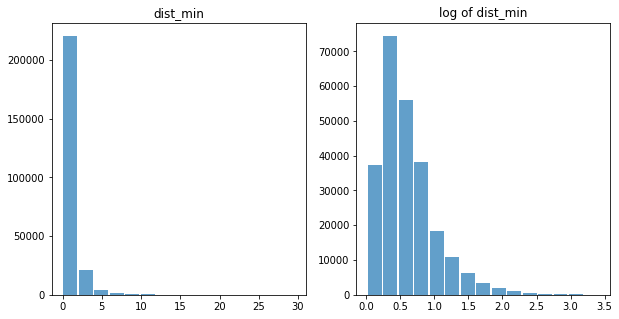

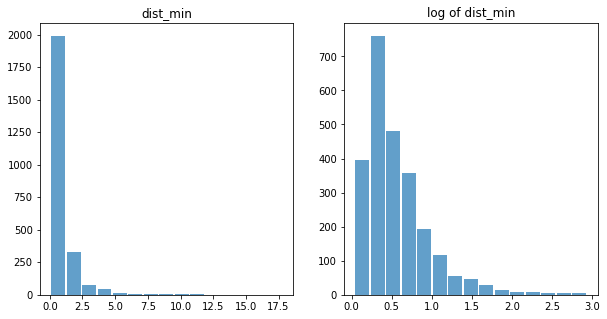

In [134]:
# dist_min

train_hist_plot('dist_min', df_train)
test_hist_plot('dist_min', df_test)

In [135]:
df_train[(df_train['dist_min'] > 15)]['dist_min'].count()

386

In [136]:
df_train = df_train[(df_train['dist_min'] <= 15)]

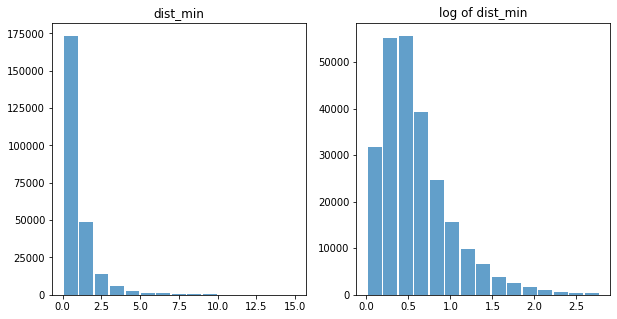

In [137]:
train_hist_plot('dist_min', df_train[(df_train['dist_min'] <= 15)])

In [138]:
df_train['dist_min_log'] = np.log(df_train['dist_min'] + 1)
df_test['dist_min_log'] = np.log(df_test['dist_min'] + 1)

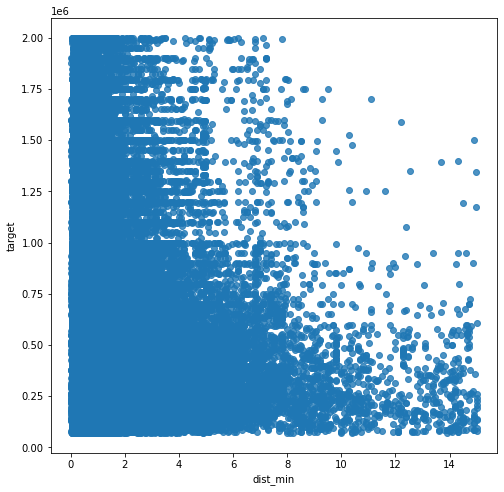

In [139]:
plt.figure(figsize = (8, 8))
sns.regplot(data=df_train, y="target", x="dist_min", fit_reg=False)
plt.show()

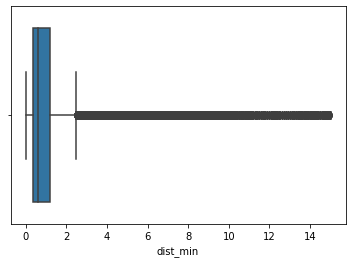

,count,min,mean,max,low_range,upper_range,out_count
dist_min,285190.0,0.01,1.08,1590.38,-0.95,2.49,22413.0


In [140]:
# График выбросов
sns.boxplot(x=df_train["dist_min"])
plt.show()

# Выбросы
data_out.loc['dist_min'].to_frame().T

In [141]:
# Удаляем предварительно ненужное

# df_train = df_train[df_train['dist_min'] < 30]

In [142]:
# Удалим выбросы

# low_r = data_out.loc['dist_min', 'low_range']
# upp_r = data_out.loc['dist_min', 'upper_range']

# df_train = df_train[(df_train['dist_min'] >= low_r) & (df_train['dist_min'] <= upp_r)]

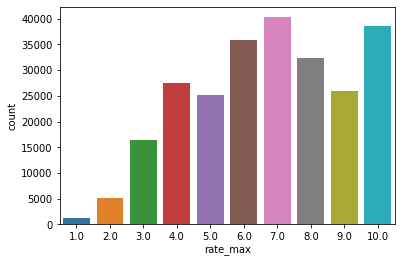

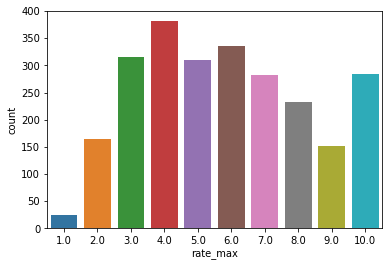

In [143]:
# rate_max

sns.countplot(x=df_train["rate_max"], data=df_train)
plt.show()

sns.countplot(x=df_test["rate_max"], data=df_test)
plt.show()

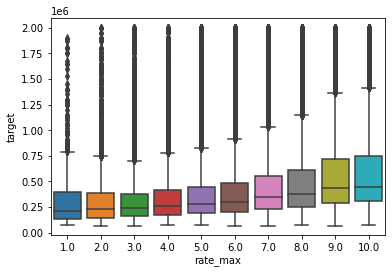

In [144]:
sns.boxplot(data=df_train, x='rate_max', y='target')
plt.show()

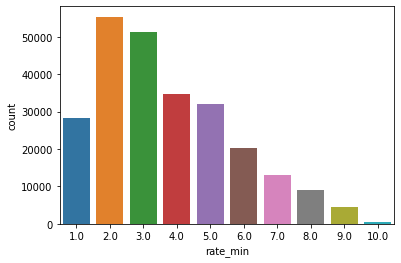

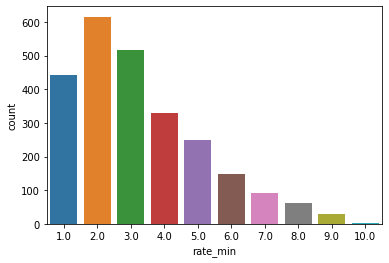

In [145]:
# rate_min

sns.countplot(x=df_train["rate_min"], data=df_train)
plt.show()

sns.countplot(x=df_test["rate_min"], data=df_test)
plt.show()

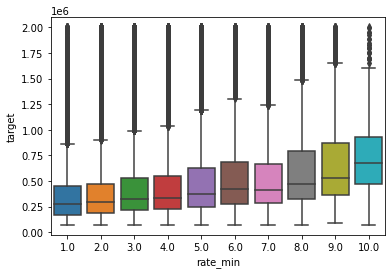

In [146]:
sns.boxplot(data=df_train, x='rate_min', y='target')
plt.show()

In [147]:
# Работа с таргетом  ?

# Влияние числовых признаков на target

In [148]:
display(df_train.columns)
print(numerical_features)

Index(['propertyType', 'sqft', 'zipcode', 'state', 'target', 'Year built',
       'dist_max', 'dist_min', 'rate_max', 'rate_min', 'target_log',
       'sqft_log', 'year_built_log', 'dist_max_log', 'dist_min_log'],
      dtype='object')

['sqft', 'Year built', 'dist_max', 'dist_min', 'rate_max', 'rate_min']


In [149]:
# Введем новые числовые признаки
numerical_features = numerical_features + ['sqft_log', 'year_built_log', 'dist_max_log', 'dist_min_log']

<AxesSubplot:>

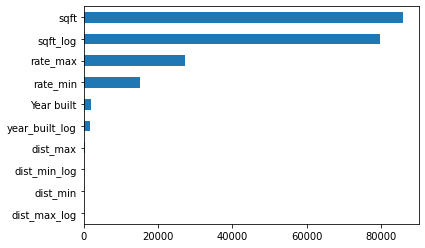

In [150]:
# График влияния числовых переменных на target

df_train_imp = df_train.copy()

# рассмотрим значимость переменных

imp_num = pd.Series(f_regression(df_train_imp[numerical_features], 
                              df_train_imp['target_log'])[0], index=numerical_features)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [151]:
# График влияния числовых переменных на target

# df_train_imp = df_train.copy()

# # рассмотрим значимость переменных
# label_encoder = LabelEncoder()

# imp_num = pd.Series(mutual_info_regression(df_train_imp[numerical_features_new], 
#                               df_train_imp['target_log']), index=numerical_features_new)
# imp_num.sort_values(inplace = True)
# imp_num.plot(kind = 'barh')

# Рассмотрим категориальные переменные

In [152]:
df_train['propertyType'].value_counts()

single family                150574
condo                         34772
townhouse                     14658
multi family                   8336
condo town row                 6791
                              ...  
contemporary other patio          1
colonial english georgian         1
condo town southwestern           1
custom victorian                  1
townhouse villa                   1
Name: propertyType, Length: 712, dtype: int64

In [153]:
df_test['propertyType'].value_counts()

single family                1814
other                         181
condo                         157
apartment                     124
multi family                   48
townhouse                      48
singlefamilyresidence          41
lot land                       20
mobile manufactured            15
multiple occupancy             13
miscellaneous                   8
cooperative                     2
apartment condo townhouse       2
mfd mobile                      1
coop                            1
traditional                     1
federal                         1
contemporary                    1
colonial                        1
unknown                         1
land                            1
Name: propertyType, dtype: int64

In [154]:
unique_train_type = df_train['propertyType'].unique()

df_test[~df_test['propertyType'].isin(unique_train_type)]['propertyType'].value_counts()

singlefamilyresidence        41
apartment condo townhouse     2
Name: propertyType, dtype: int64

In [155]:
# Так как количетсво этих значений мало, заменим на аналогичное из теста

df_test.loc[df_test['propertyType'] == 'apartment condo townhouse', 'propertyType'] = 'apartment'
df_test.loc[df_test['propertyType'] == 'singlefamilyresidence', 'propertyType'] = 'single family'

In [156]:
unique_type = df_test['propertyType'].unique()

# Удалим строки из трейна, где нет значений из теста
df_train = df_train[df_train['propertyType'].isin(unique_type)]

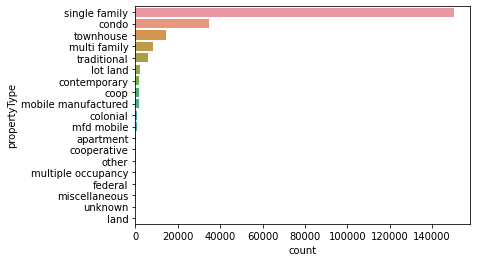

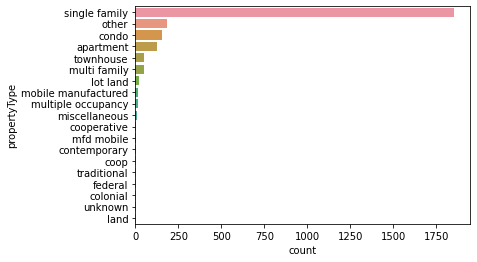

In [157]:
# Посмотрим как распределены значения в трейне и тесте

sns.countplot(y="propertyType", data=df_train, order = df_train['propertyType'].value_counts().index)
plt.show()

sns.countplot(y="propertyType", data=df_test, order = df_test['propertyType'].value_counts().index)
plt.show()

In [158]:
# Более сильное упрощение дает результат хуже

In [159]:
df_train['zipcode'].value_counts()

33131    1198
33132     954
33137     912
33130     899
32137     865
         ... 
10707       1
33559       1
32792       1
61102       1
64015       1
Name: zipcode, Length: 3912, dtype: int64

In [160]:
df_test['zipcode'].value_counts()

20019    22
33647    20
11201    19
32209    18
33712    17
         ..
30327     1
02215     1
38115     1
02128     1
04957     1
Name: zipcode, Length: 1163, dtype: int64

In [161]:
# Так как количество уникальных значений слишком много, разделим из согласно правилу 3-2

df_train.loc[:,'zip_f'] = df_train['zipcode'].apply(lambda x: str(x)[:3])
df_test.loc[:,'zip_f'] = df_test['zipcode'].apply(lambda x: str(x)[:3])

df_train.loc[:,'zip_s'] = df_train['zipcode'].apply(lambda x: str(x)[3:])
df_test.loc[:,'zip_s'] = df_test['zipcode'].apply(lambda x: str(x)[3:])


In [162]:
unique_train_zipf = df_train['zip_f'].unique()

df_test[~df_test['zip_f'].isin(unique_train_zipf)]['zip_f'].value_counts()

Series([], Name: zip_f, dtype: int64)

In [163]:
unique_train_zips = df_train['zip_s'].unique()

df_test[~df_test['zip_s'].isin(unique_train_zips)]['zip_s'].value_counts()

Series([], Name: zip_s, dtype: int64)

In [164]:
unique_zipf = df_test['zip_f'].unique()
unique_zips = df_test['zip_s'].unique()

# Удалим строки из трейна, где нет значений из теста
df_train = df_train[df_train['zip_f'].isin(unique_zipf)]
df_train = df_train[df_train['zip_s'].isin(unique_zips)]

In [165]:
# Нужно будет сократить количество уникальных значений, их сильно много

# Ввести новые признаки в датафрейм

In [166]:
df_train['state'].value_counts()

FL    66572
TX    51203
CA    15876
NY    10960
NC    10556
TN     9184
WA     8679
NV     6969
OH     5615
IL     5334
GA     4307
PA     3431
CO     3349
DC     2673
OR     2182
IN     1724
MI     1317
UT      939
MD      607
MO      524
MA      412
VT      288
VA       75
ME       37
DE        2
Name: state, dtype: int64

In [167]:
df_test['state'].value_counts()

FL    782
TX    428
CA    178
OH    156
NY    140
TN    109
DC     89
WA     87
IL     87
NC     76
GA     64
NV     61
PA     51
MI     35
MO     34
IN     34
CO     27
MA     18
OR     11
VT      4
UT      4
MD      4
VA      1
ME      1
Name: state, dtype: int64

In [168]:
# Посмотрим каких значений теста нет в трейне

unique_train_state = df_train['state'].unique()

df_test[~df_test['state'].isin(unique_train_state)]['state'].value_counts()

Series([], Name: state, dtype: int64)

In [169]:
# Удалим те строки в трейне, которых нет в тесте

unique_state = df_test['state'].unique()

df_train = df_train[df_train['state'].isin(unique_state)]


In [170]:
# Добавим новые категориальные признаки

categorical_features = categorical_features + ['zip_f', 'zip_s']

<AxesSubplot:>

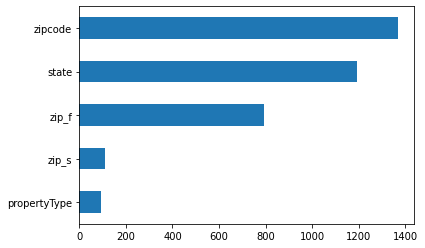

In [171]:
# Теперь рассмотрим значимость категориальных переменных
df_train_cat = df_train.copy()

label_encoder = LabelEncoder()

for feature in categorical_features:
    df_train_cat[feature] = label_encoder.fit_transform(df_train_cat[feature])

imp_cat = pd.Series(f_regression(df_train_cat[categorical_features], 
                              df_train_cat['target_log'])[0], index=categorical_features)

imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [172]:
# Замечание: влияние кат переменных на target и target_log разное

In [173]:
# # Теперь рассмотрим значимость категориальных переменных

# df_train_cat = df_train.copy()

# # рассмотрим значимость переменных
# label_encoder = LabelEncoder()

# for feature in categorical_features:
#     df_train_cat[feature] = label_encoder.fit_transform(df_train_cat[feature])

# imp_cat = pd.Series(mutual_info_regression(df_train_cat[categorical_features], 
#                               df_train_cat['target_log']), index=numerical_features_new)
# imp_cat.sort_values(inplace = True)
# imp_cat.plot(kind = 'barh')

Prepocess data

In [174]:
numerical_features_copy = numerical_features.copy()
categorical_features_copy = categorical_features.copy()

In [175]:
print(numerical_features_copy)
print(categorical_features_copy)

['sqft', 'Year built', 'dist_max', 'dist_min', 'rate_max', 'rate_min', 'sqft_log', 'year_built_log', 'dist_max_log', 'dist_min_log']
['propertyType', 'zipcode', 'state', 'zip_f', 'zip_s']


In [176]:
# Удаляем признаки из numerical_features_new
for x in ['sqft', 'dist_max', 'dist_min', 'rate_max', 'rate_min', 'year_built_log']:
    numerical_features_copy.remove(x)

# numerical_features_copy.remove('dist_min_log')
# numerical_features_copy.remove('dist_max_log')

categorical_features_copy.remove('zipcode')
# categorical_features_copy.remove('propertyType')
# categorical_features_copy.remove('zip_f')
# categorical_features_copy.remove('zip_s')

for x in ['rate_max', 'rate_min']:
    categorical_features_copy.append(x)   
    
features = numerical_features_copy + categorical_features_copy + ['target_log']
# features = numerical_features_new + categorical_features + ['target']

In [177]:
# Мы знаем, что у трейна нет target=0, все эти данные в тесте, поэтому можем легко их оюъединить

df_input = pd.concat([df_train[features], df_test[features]])

In [178]:
df_input.sample(5)

,Year built,sqft_log,dist_max_log,dist_min_log,propertyType,state,zip_f,zip_s,rate_max,rate_min,target_log
326163,2000.0,6.955593,0.693147,0.336472,single family,GA,310,88,6.0,4.0,0.000000
107830,2016.0,7.489971,1.332366,0.751416,single family,FL,321,64,5.0,4.0,12.560248
168677,2012.0,6.498282,3.144152,0.875469,condo,FL,331,37,10.0,2.0,12.487489
48476,1905.0,7.194437,0.698135,0.215111,single family,NY,103,01,5.0,2.0,12.896719
150653,1986.0,7.678326,1.193922,0.875469,single family,PA,191,28,4.0,1.0,12.959611


In [179]:
from sklearn.preprocessing import PolynomialFeatures

In [180]:
poly = PolynomialFeatures(degree=1, include_bias=False)

df_numerical_poly = pd.DataFrame(poly.fit_transform(df_input[numerical_features_copy]))

In [181]:
# числовые полиномиальные признаки с критерием (degree=2, 3) не дают улучшения модели

In [182]:
df_numerical_poly.shape

(215294, 4)

In [183]:
# One-Hot Encoding
df_categorical_dummy = pd.get_dummies(df_input[categorical_features_copy], dummy_na=False).reset_index(drop=True)

In [184]:
df_preproc = pd.concat([df_numerical_poly, df_categorical_dummy, pd.Series(df_input['target_log']).reset_index(drop=True)], axis=1)

In [185]:
df_preproc.shape

(215294, 360)

In [186]:
# Сделать KBest признаков

Split data

In [187]:
# Теперь выделим тестовую часть
train_data = df_preproc[df_preproc['target_log'] != 0]
test_data = df_preproc[df_preproc['target_log'] == 0]

X_train_num = train_data[df_numerical_poly.columns].values
X_test_num = test_data[df_numerical_poly.columns].values

X_train_cat = train_data[df_categorical_dummy.columns].values
X_test_cat = test_data[df_categorical_dummy.columns].values

In [188]:
# Scaler
scaler = StandardScaler()
scaler.fit(X_train_num)

X_train_num = scaler.transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

In [189]:
X = np.hstack([X_train_num, X_train_cat])
Y = train_data['target_log'].values
test_val = np.hstack([X_test_num, X_test_cat])

Select Kbest

In [190]:
# selector = SelectKBest(score_func=f_regression, k=300)

# X = selector.fit_transform(X, Y)
# cols = selector.get_support(indices=True)
# test_val = test_val[:, cols]

# Уменьшение количества признаков не улучшает результат

# Trying to save changes and load it (state)!

In [191]:
#import dill
#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

# SPLIT

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

# CatBoostRegressor

In [230]:
model_cbr = CatBoostRegressor(iterations = 5000,
                                #depth=8,
                                #learning_rate = 0.42,
                                random_seed = RANDOM_SEED,
                                eval_metric='MAPE',
                                custom_metric=['RMSE'],
                                od_wait=100,
                                #task_type='GPU',
                         )

model_cbr.fit(X_train, y_train,
              eval_set=(X_test, y_test),
              verbose_eval=0,
              use_best_model=True,
         )

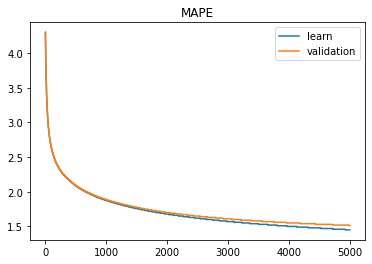

In [231]:
# График обучения

learn_mape = [round(x * 100, 2) for x in model_cbr.evals_result_['learn']['MAPE']]
valid_mape = [round(x * 100, 2) for x in model_cbr.evals_result_['validation']['MAPE']]

# plt.figure(figsize=(15, 7))
plt.title('MAPE')
plt.plot(learn_mape, label='learn')
plt.plot(valid_mape, label='validation')
plt.legend()
plt.show()

In [232]:
y_pred = model_cbr.predict(X_test)

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

print(f"TEST mape: {mean_absolute_percentage_error(y_test_exp, y_pred_exp)*100:0.2f}%")


TEST mape: 19.83%


Результат на 1000 21.39%

Результат на 5000 19.83%

# Настройка оценки grid_search

In [225]:
model_cbr = CatBoostRegressor(iterations = 1000,
                              random_seed = RANDOM_SEED,
                              eval_metric='MAPE',
                              od_wait=100,
                          )

parameters = {'depth': sp_randInt(4, 10),
                'learning_rate': sp_randFloat(),
                }

randm = RandomizedSearchCV(estimator=model_cbr, param_distributions = parameters, n_jobs=-1)

randm.fit(X_train, y_train, verbose_eval=0)

best_param = randm.best_params_
best_param


{'depth': 9, 'learning_rate': 0.23943301858650679}

Результат на 1000 depth 8, learning rate = 0.43

Результат на 1000 depth 9, learning rate = 0.24

In [235]:
# Использование в модели

model_cbr = CatBoostRegressor(iterations = 5_000,
                          depth=9,
                          learning_rate = 0.24,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE'],
                          od_wait=100,
                          #task_type='GPU',
                         )

model_cbr.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         )

y_pred = model_cbr.predict(X_test)

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

print(f"TEST mape: {mean_absolute_percentage_error(y_test_exp, y_pred_exp)*100:0.2f}%")

TEST mape: 16.49%


Результат на 5000, depth=8, learning rate = 0.42 значение 16.85%

Результат на 5000, depth=9, learning rate = 0.24 значение 16.49%

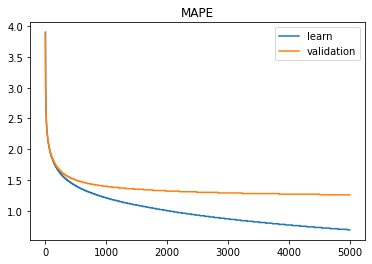

In [236]:
# График обучения

learn_mape = [round(x * 100, 2) for x in model_cbr.evals_result_['learn']['MAPE']]
valid_mape = [round(x * 100, 2) for x in model_cbr.evals_result_['validation']['MAPE']]

# plt.figure(figsize=(15, 7))
plt.title('MAPE')
plt.plot(learn_mape, label='learn')
plt.plot(valid_mape, label='validation')
plt.legend()
plt.show()

# RandomForestRegressor

In [238]:
model_rfr = RandomForestRegressor(random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model_rfr.fit(X_train, y_train)
y_pred = model_rfr.predict(X_test)

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 19.09%


Результат 19.09%

In [199]:
model_rfr = RandomForestRegressor(random_state=RANDOM_SEED)


parameters = {'max_depth': [None, sp_randInt(4, 10)],
                'n_estimators': sp_randInt(70, 150),
                'max_features': ['auto', 'sqrt', 'log2'],
                }

randm_rfr = RandomizedSearchCV(estimator=model_rfr, param_distributions=parameters, n_jobs=-1)

randm_rfr.fit(X_train, y_train)

best_param = randm_rfr.best_params_
best_param

Результат max_depth = None, n_estimators = 109, max_features = 'log2'

In [239]:
# Использование в модели

model_rfr = RandomForestRegressor(random_state=RANDOM_SEED, max_depth=None, n_estimators=109, max_features='log2')

# Обучаем модель на тестовом наборе данных
model_rfr.fit(X_train, y_train)
y_pred = model_rfr.predict(X_test)

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 17.28%


Результат на max_depth=None, n_estimators=109, max_features='log2' значение 17.28%

# KNeighborsRegressor

In [240]:
model_knr = KNeighborsRegressor()

# Обучаем модель на тестовом наборе данных
model_knr.fit(X_train, y_train)
y_pred = model_knr.predict(X_test)

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 20.25%


Результат 20.25%

In [245]:
model_knr = KNeighborsRegressor()


parameters = {'n_neighbors': sp_randInt(4, 10),
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'leaf_size': sp_randInt(20, 50),
                }

randm_knr = RandomizedSearchCV(estimator=model_knr, param_distributions=parameters, n_jobs=-1)

randm_knr.fit(X_train, y_train)

best_param = randm_knr.best_params_
best_param

KeyboardInterrupt: 

Результат algorithm= 'ball_tree', leaf_size = 33, n_neighbors = 5

In [246]:
# Используем в модели

model_knr = KNeighborsRegressor(n_neighbors=5, algorithm='ball_tree', leaf_size=33)

# Обучаем модель на тестовом наборе данных
model_knr.fit(X_train, y_train)
y_pred = model_knr.predict(X_test)

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 20.25%


Результат на n_neighbors=5, algorithm='ball_tree', leaf_size=33 значение 20.25

# Linear

In [242]:
from sklearn.linear_model import Ridge

In [243]:
model_rdg = Ridge(random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model_rdg.fit(X_train, y_train)
y_pred = model_rdg.predict(X_test)

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 29.29%


Результат 29.29%

In [206]:
model_rdg = Ridge(random_state=RANDOM_SEED)


parameters = {'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                'max_iter': [None, sp_randInt(800, 2000)],
                'alpha': sp_randFloat(),
                }

randm_rdg = RandomizedSearchCV(estimator=model_rdg, param_distributions=parameters, n_jobs=-1)

randm_rdg.fit(X_train, y_train)

best_param = randm_rdg.best_params_
best_param

In [249]:
model_rdg = Ridge(random_state=RANDOM_SEED, max_iter=None, solver='sag', alpha=0.33)

# Обучаем модель на тестовом наборе данных
model_rdg.fit(X_train, y_train)
y_pred = model_rdg.predict(X_test)

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 29.29%


Результат на max_iter=None, solver='sag', alpha=0.33 значение 29.29%

Вывод: Оптимизация улучшения не дает

# DENSE

In [476]:
model = Sequential()
model.add(Dense(32, activation='elu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(1, activation='elu'))

In [477]:
# print(model.summary())

In [478]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mape', metrics=['mape'])

In [479]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_mape', factor=0.1,
                              patience=5, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_mape', restore_best_weights=True, patience=50)

In [480]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=500, 
                    validation_split=0.3,
                    verbose=0,
                    callbacks=[reduce_lr, early_stop],
                    )

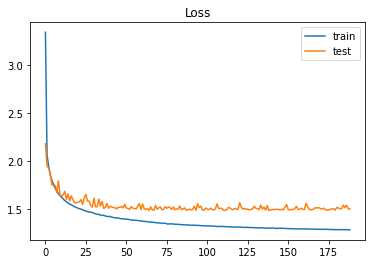

In [481]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [482]:
y_pred = model.predict(X_test).flatten() 

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 18.95%


Результат на 100 эпохах 32-32-32-1 19.08%

Результат на 500 эпохых с callbacks 32-32-32-1 значение 18.95%

In [216]:
# Как видно, нейронная есть не дает существнных улучшений по разным наборам.

# Stacking

In [217]:
# Оптимизируем модель

from sklearn.ensemble import StackingRegressor


estimators = [
    ('knr', KNeighborsRegressor(n_neighbors=5, algorithm='ball_tree', leaf_size=33)),
    ('rdg', Ridge(random_state=RANDOM_SEED, max_iter=None, solver='sag', alpha=0.33))
    ]

final_model = RandomForestRegressor(random_state=RANDOM_SEED, max_depth=None, n_estimators=109, max_features='log2')

model_str = StackingRegressor(
    estimators=estimators,
    final_estimator=final_model
    )

In [218]:
# Обучаем модель

model_str.fit(X_train, y_train)
         
y_pred = model_str.predict(X_test)

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

Результат 21.49%

# Submission

In [219]:
# price_out = pd.DataFrame(list(zip(y_pred_exp, y_test_exp)), columns = ['y_pred_exp', 'y_test_exp'])
# # price_out.to_csv('price_out.csv')